In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import numpy as np


from numpy import quantile
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Load datasets

In [2]:
pressures_df = pd.read_csv("../data/final_data/pressures_node21.csv").set_index("Timestamp")
flows_df = pd.read_csv("../data/final_data/flows_link21.csv").set_index("Timestamp")

# Split data into train and validation set

## Pressures

In [3]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    pressures_df.drop(["label", "node_21_forecast"], axis=1),
    pressures_df["label"],
    train_size=0.8,
    random_state=29
)

## Flows

In [4]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    flows_df.drop(["label", "link_21_forecast"], axis=1),
    flows_df["label"],
    train_size=0.8,
    random_state=29
)

# Distributions of training data

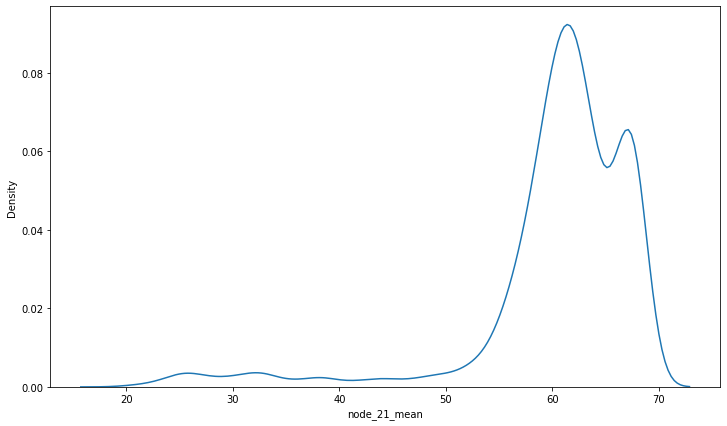

In [5]:
plt.figure(figsize=(12, 7))
sns.kdeplot(data=X_train_p, x="node_21_mean")
plt.show()

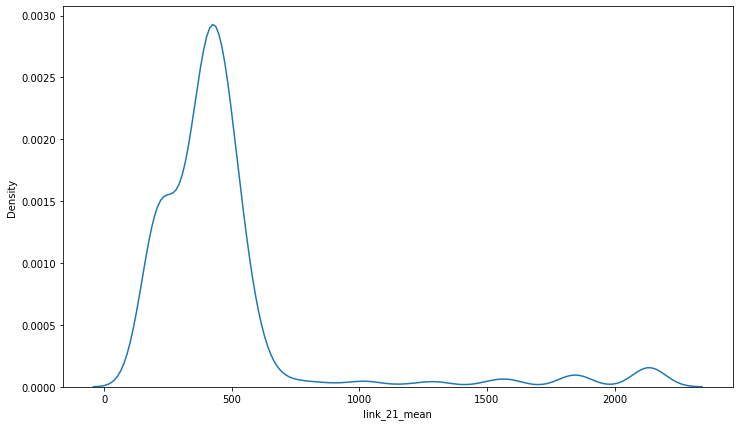

In [6]:
plt.figure(figsize=(12, 7))
sns.kdeplot(data=X_train_f, x="link_21_mean")
plt.show()

# Estimation of density

## Pressures

In [7]:
kde_p = KernelDensity()
kde_p.fit(X_train_p[["node_21_mean"]])

KernelDensity()

## Flows

In [8]:
kde_f = KernelDensity()
kde_f.fit(X_train_f[["link_21_mean"]])

KernelDensity()

# Estimation of the best threshold

## Pressures

In [9]:
scores_p = kde_p.score_samples(X_train_p[["node_21_mean"]])
press_used = X_train_p.copy()
press_used["scores"] = scores_p

In [10]:
threshold = quantile(scores_p, 0.001)
press_used["prediction"] = press_used["scores"].apply(lambda x: 1 if x < threshold else 0)
accuracy = accuracy_score(y_true=y_train_p, y_pred=press_used["prediction"])
best_threshold = threshold
best_quantile = 0.001
for quantile_value in np.arange(0.002, 1, 0.001):
    new_threshold = quantile(scores_p, quantile_value)
    press_used["prediction"] = press_used["scores"].apply(lambda x: 1 if x < new_threshold else 0)
    new_accuracy = accuracy_score(y_true=y_train_p, y_pred=press_used["prediction"])
    if new_accuracy > accuracy:
        accuracy = new_accuracy
        best_threshold = new_threshold
        best_quantile = quantile_value

In [11]:
accuracy

0.9523401826484018

In [12]:
best_threshold

-5.405833145233293

In [13]:
best_quantile

0.076

In [14]:
press_used["node_21_mean"].quantile(best_quantile)

51.462613999999995

In [15]:
press_used["prediction"] = press_used["scores"].apply(lambda x: 1 if x < best_threshold else 0)

In [16]:
press_used["prediction"].value_counts()

0    6475
1     533
Name: prediction, dtype: int64

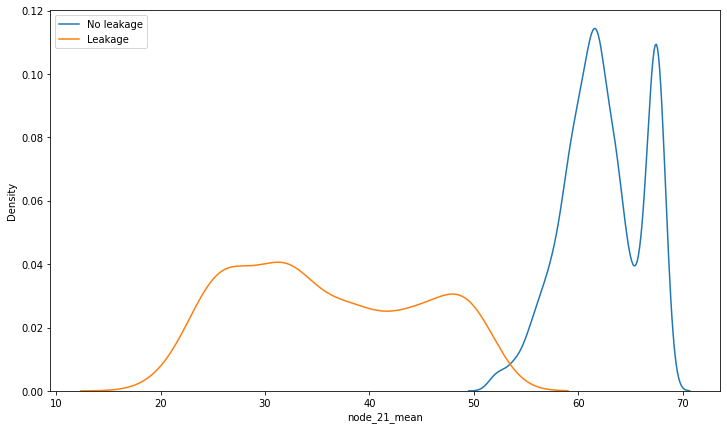

In [17]:
plt.figure(figsize=(12, 7))
sns.kdeplot(data=press_used[press_used["prediction"]==0], x="node_21_mean", label="No leakage")
sns.kdeplot(data=press_used[press_used["prediction"]==1], x="node_21_mean", label="Leakage")
plt.legend()
plt.show()

In [18]:
scores_p_test = kde_p.score_samples(X_test_p[["node_21_mean"]])
press_predict = X_test_p.copy()
press_predict["scores"] = scores_p_test
predictions = press_predict["scores"].apply(lambda x: 1 if x < best_threshold else 0)

In [19]:
accuracy_test = accuracy_score(y_true=y_test_p, y_pred=predictions)
accuracy_test

0.9429223744292238

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      1547
         1.0       0.93      0.56      0.70       205

    accuracy                           0.94      1752
   macro avg       0.94      0.78      0.83      1752
weighted avg       0.94      0.94      0.94      1752



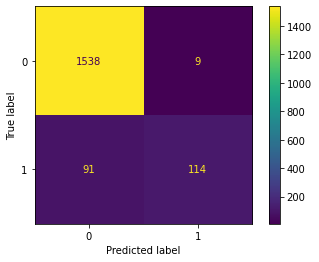

In [20]:
print(classification_report(y_pred=predictions, y_true=y_test_p))
cm = confusion_matrix(y_true=y_test_p, y_pred=predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

In [21]:
threshold_test = quantile(scores_p_test, best_quantile)

In [22]:
predictions_2 = press_predict["scores"].apply(lambda x: 1 if x < threshold_test else 0)

In [23]:
accuracy_test_2 = accuracy_score(y_true=y_test_p, y_pred=predictions_2)
accuracy_test_2

0.942351598173516

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97      1547
         1.0       0.89      0.58      0.70       205

    accuracy                           0.94      1752
   macro avg       0.92      0.79      0.84      1752
weighted avg       0.94      0.94      0.94      1752



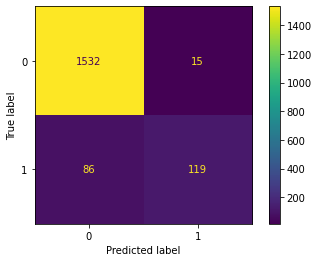

In [24]:
print(classification_report(y_pred=predictions_2, y_true=y_test_p))
cm = confusion_matrix(y_true=y_test_p, y_pred=predictions_2, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

## Flows

In [25]:
scores_f = kde_f.score_samples(X_train_f[["link_21_mean"]])
flows_used = X_train_f.copy()
flows_used["scores"] = scores_f

In [26]:
threshold_f = quantile(scores_f, 0.001)
flows_used["prediction"] = flows_used["scores"].apply(lambda x: 1 if x < threshold_f else 0)
accuracy_f = accuracy_score(y_true=y_train_f, y_pred=flows_used["prediction"])
best_threshold_f = threshold_f
best_quantile_f = 0.001
for quantile_value_f in np.arange(0.002, 1, 0.001):
    new_threshold_f = quantile(scores_f, quantile_value_f)
    flows_used["prediction"] = flows_used["scores"].apply(lambda x: 1 if x < new_threshold_f else 0)
    new_accuracy_f = accuracy_score(y_true=y_train_f, y_pred=flows_used["prediction"])
    if new_accuracy_f > accuracy_f:
        accuracy_f = new_accuracy_f
        best_threshold_f = new_threshold_f
        best_quantile_f = quantile_value_f

In [27]:
accuracy_f

0.9228025114155252

In [28]:
best_threshold_f

-8.09309211431842

In [29]:
best_quantile_f

0.060000000000000005

In [30]:
flows_used["link_21_mean"].quantile(best_quantile_f)

195.85200000000003

In [31]:
flows_used["prediction"] = flows_used["scores"].apply(lambda x: 1 if x < best_threshold_f else 0)

In [32]:
flows_used["prediction"].value_counts()

0    6588
1     420
Name: prediction, dtype: int64

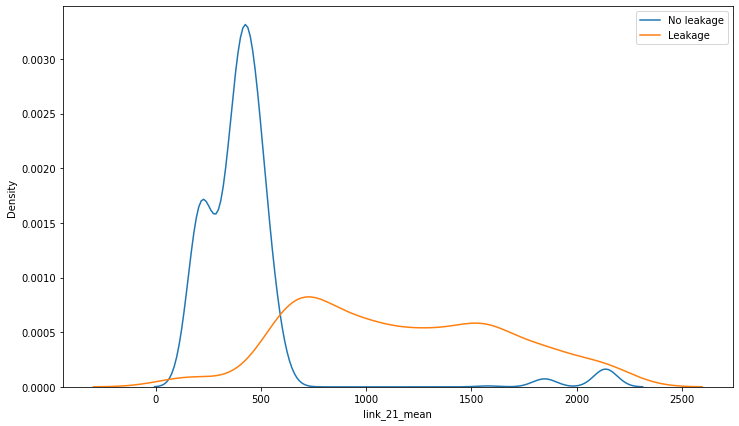

In [33]:
plt.figure(figsize=(12, 7))
sns.kdeplot(data=flows_used[flows_used["prediction"]==0], x="link_21_mean", label="No leakage")
sns.kdeplot(data=flows_used[flows_used["prediction"]==1], x="link_21_mean", label="Leakage")
plt.legend()
plt.show()

In [34]:
scores_f_test = kde_f.score_samples(X_test_f[["link_21_mean"]])
flows_fredict = X_test_f.copy()
flows_fredict["scores"] = scores_f_test
predictions_f = flows_fredict["scores"].apply(lambda x: 1 if x < best_threshold_f else 0)

In [35]:
accuracy_test_f = accuracy_score(y_true=y_test_f, y_pred=predictions_f)
accuracy_test_f

0.91324200913242

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      1547
         1.0       0.75      0.39      0.51       205

    accuracy                           0.91      1752
   macro avg       0.84      0.69      0.73      1752
weighted avg       0.90      0.91      0.90      1752



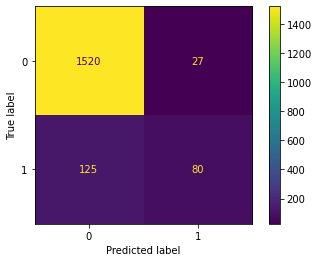

In [36]:
print(classification_report(y_pred=predictions_f, y_true=y_test_f))
cm = confusion_matrix(y_true=y_test_f, y_pred=predictions_f, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()

In [37]:
threshold_test_f = quantile(scores_f_test, best_quantile_f)
predictions_f_2 = flows_fredict["scores"].apply(lambda x: 1 if x < threshold_test_f else 0)
accuracy_test_f_2 = accuracy_score(y_true=y_test_f, y_pred=predictions_f_2)
accuracy_test_f_2

0.9126712328767124

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      1547
         1.0       0.75      0.39      0.51       205

    accuracy                           0.91      1752
   macro avg       0.83      0.68      0.73      1752
weighted avg       0.90      0.91      0.90      1752



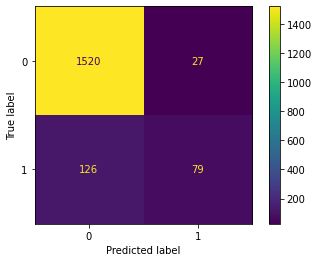

In [38]:
print(classification_report(y_pred=predictions_f_2, y_true=y_test_f))
cm = confusion_matrix(y_true=y_test_f, y_pred=predictions_f_2, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
disp.plot()